# Income prediction based on census data

## Introduction

The prediction task is to determine whether a person makes over 50K a year.

In this report, I will use logistic regression and deep neural network (DNN model).

## Dataset

This dataset is downloaded from Kaggle.

Data recource: UCI machine learning repository

## import some libraries and our dataset.

In [1]:
# Import some libraries
import pandas as pd
import numpy as np
import matplotlib as mlt
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

In [2]:
# Import datasets
train_data=pd.read_csv('/Users/Stylewsxcde991/Desktop/物聯網下商管統計分析/qbs-competition-1/data/train.csv',index_col=0)
X_test=pd.read_csv('/Users/Stylewsxcde991/Desktop/物聯網下商管統計分析/qbs-competition-1/data/test.csv',index_col=0)

## Look some basic information of our dataset.

In [3]:
# Some basic information of training data
print('The shape of training data: ' + str(train_data.shape))
print('')
print('The shape of training data: ' + str(X_test.shape))
print('')
print('Basic information of our training data: ')
print(train_data.info())
print('')
print('Basic information of our testing data: ')
print(X_test.info())

The shape of training data: (29514, 15)

The shape of training data: (19328, 14)

Basic information of our training data: 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 29514 entries, 2 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             29514 non-null  int64 
 1   Workclass       27665 non-null  object
 2   fnlwgt          29514 non-null  int64 
 3   Education       29514 non-null  object
 4   Education_Num   29514 non-null  int64 
 5   Martial_Status  29514 non-null  object
 6   Occupation      27657 non-null  object
 7   Relationship    29514 non-null  object
 8   Race            29514 non-null  object
 9   Sex             29514 non-null  object
 10  Capital_Gain    29514 non-null  int64 
 11  Capital_Loss    29514 non-null  int64 
 12  Hours_per_week  29514 non-null  int64 
 13  Country         28988 non-null  object
 14  Target          29514 non-null  int64 
dtypes: int64(7), ob

According to above information, the shape of training data is (29514, 15) and the shape of test data is (19328, 14).
    
Furthermore, notice that we have missing data problem in our training dataset and test dataset (there are Null value in some features). 

In particular, we have to deal with the missing data problem of 'Workclass', 'Occupation', 'Country' in our training dataset and testing dataset. We can deal with this problem by replacing all Null value with 'unknown'.

## Deal with missing data

In [4]:
# Deal with missing data
train_data.Workclass=train_data.Workclass.fillna('unknown')
train_data.Occupation=train_data.Occupation.fillna('unknown')
train_data.Country=train_data.Country.fillna('unknown')
X_test.Workclass=X_test.Workclass.fillna('unknown')
X_test.Occupation=X_test.Occupation.fillna('unknown')
X_test.Country=X_test.Country.fillna('unknown')

## Proportion of each target class (make over 50k a year or not).

NotOver50k 26008
Over50k 3506
Over50k proportion 11.88%


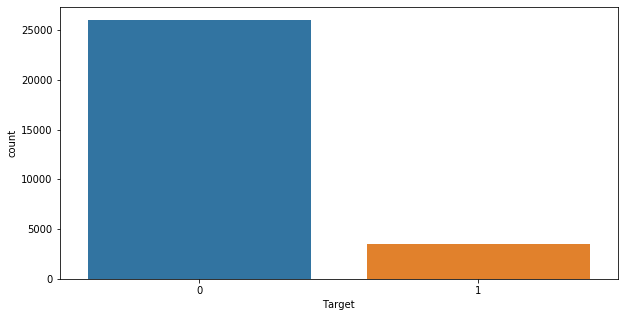

In [5]:
# The proportion of each target class
NotOver50k,Over50k = train_data.Target.value_counts()
print(f'NotOver50k {NotOver50k}')
print(f'Over50k {Over50k}')
print(f'Over50k proportion {round((100*Over50k/(Over50k+NotOver50k)),2)}%')
plt.figure(figsize=(10,5))
sns.countplot(train_data['Target'])

According to above calculation and plot, there are only 11.88% samples makes over 50K a year. 

Therefore, our training dataset is quiet imbalanced.

## Exploratory data analysis for numerical features

As following, we analyze the correlation coefficients between our numerical features.

Text(0.5, 1, 'Heatmap showing correlations between numerical data')

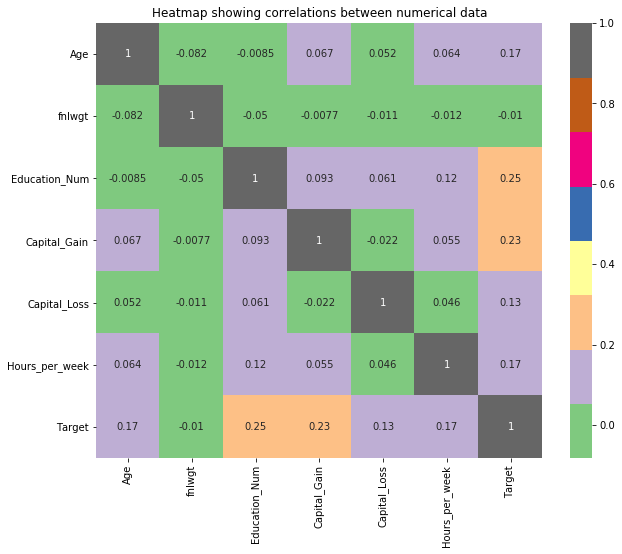

In [6]:
# EDA for numerical features
# data.corr()
plt.figure(figsize=(10,8))  
sns.heatmap(train_data.corr(),cmap='Accent',annot=True)
plt.title('Heatmap showing correlations between numerical data')

One thing to note is that the correlation coefficient between 'fnlwgt' and our target is quiet small (which is -0.01).

Therefore, I don't consider 'fnlwgt' in my NN models.

(In fact, I have tried to incorporate 'fnlwgt' in my NN models and got really bad results.)

In addition, because I think 'Education' and 'Education_Num' contain the same information, I only use 'Education_Num' in my NN models.

## Exploratory data analysis for categorical features.

In [7]:
# Drop 'fnlwgt' & 'Education'
train_data = train_data.drop(columns=['fnlwgt','Education'])
X_test = X_test.drop(columns=['fnlwgt','Education'])

[Text(0, 0.5, 'Fraction of people with income > $50k')]

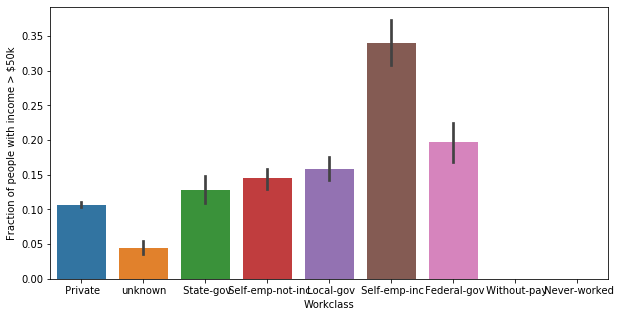

In [8]:
# EDA for categorical features
plt.figure(figsize=(10,5))
ax = sns.barplot(x='Workclass',y='Target',data=train_data)
ax.set(ylabel='Fraction of people with income > $50k')

As above, people who are 'Self-emp-inc' are more likely makes over 50K a year.

[Text(0, 0.5, 'Fraction of people with income > $50k')]

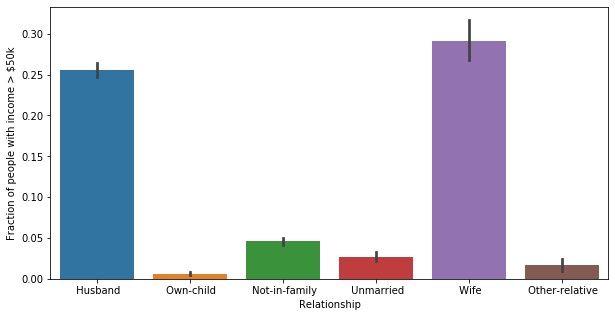

In [9]:
plt.figure(figsize=(10,5))
ax = sns.barplot(x='Relationship',y='Target',data=train_data)
ax.set(ylabel='Fraction of people with income > $50k')

As above, 'Husband' and 'Wife' are more likely makes over 50K a year.

[Text(0, 0.5, 'Fraction of people with income > $50k')]

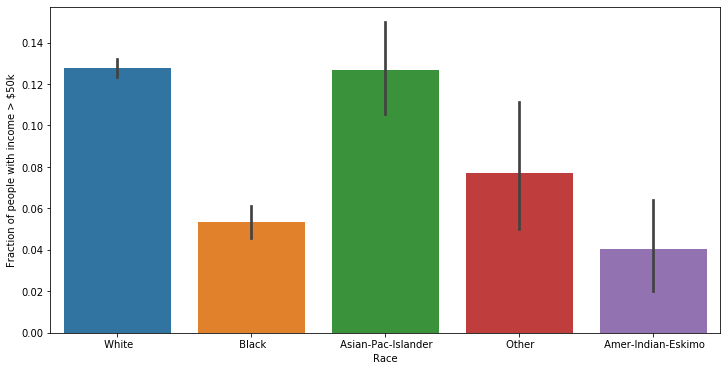

In [10]:
plt.figure(figsize=(12,6))
ax=sns.barplot(x='Race',y='Target',data=train_data)
ax.set(ylabel='Fraction of people with income > $50k')

As above, 'White' and 'Asian-Pac-Islander Race' have higher proportion of people who make over 50K a year.

[Text(0, 0.5, 'Fraction of people with income > $50k')]

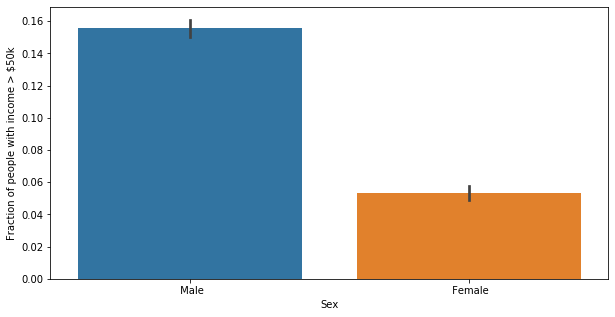

In [11]:
plt.figure(figsize=(10,5))
ax = sns.barplot(x='Sex',y='Target',data=train_data)
ax.set(ylabel='Fraction of people with income > $50k')

As above, 'Male' group has higher proportion of people who make over 50K a year.

## Split the training data into features (X) and label (y).

In [12]:
# Split our train_data
X_train=train_data.iloc[:,:-1]
y_train=train_data.iloc[:,-1]

Now, we have to deal with the issue of categorical features.

In our training data and testing data, we have many categorical features ('Workclass','Martial_Status', 'Education',
'Occupation','Relationship','Race','Sex','Country'). Because our NN models can only deal with numbers, we have to encode these categorical features into numbers.

In fact, there are many different ways to encode categorical features. The method I used is so-called 'One-hot encoding' (as following).

## One-hot encoding

In [13]:
# Use 'One-hot encoding' to encode categorical features.
X = X_train.append(X_test)
X = pd.get_dummies(X)
X_train = X[:29514]
X_test = X[29514:]

# Standardize the data

In [14]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler().fit(X_train)
X_train=sc.transform(X_train)
X_test=sc.transform(X_test)

Now, we transform our datasets from dataframes to arrays, so we can feed them into NN models.

In addition, we use 7500 samples in our training dataset to be our validation set and use other samples to train our NN models.

In [15]:
# Change dataframes to arrays
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
y_train = np.asarray(y_train).astype('float32')

# validation set
X_valid = X_train[:7500]
partial_X_train = X_train[7500:]
y_valid = y_train[:7500]
partial_y_train = y_train[7500:]

## Logistic Regression

So far, we have dealed with all issues of data pre-processing. 

Now, we can start to build our logistic regression model.

In [20]:
# logistic model
from sklearn.linear_model import LogisticRegression
logistic_model = LogisticRegression(random_state=0).fit(X_train, y_train)

In [21]:
# Compute the confusion matrix
y_preds = logistic_model.predict(X_valid)
y_preds = (y_preds>0.5).astype(int)
print('confusion matrix')
print(sklearn.metrics.confusion_matrix(y_valid,y_preds))

# Compute accuracy
print('accuracy = '+ str(sklearn.metrics.accuracy_score(y_valid,y_preds)))


# Compute Precision
print('precision = '+str(sklearn.metrics.precision_score(y_valid,y_preds)))
      
# Compute Recall
print('recall = '+ str(sklearn.metrics.recall_score(y_valid,y_preds)))

# Compute F1 score
print('F1 score = '+ str(sklearn.metrics.f1_score(y_valid,y_preds)))

confusion matrix
[[6496  118]
 [ 528  358]]
accuracy = 0.9138666666666667
precision = 0.7521008403361344
recall = 0.4040632054176072
F1 score = 0.5256975036710719


## Deep neural network (DNN model)

Now, we can start to build our NN models.

<mark>DL model draft:<mark>  
    
3 hidden layers in this model.

The first hidden layer: 16 units with 'relu' activation function.

The second hidden layer: 16 units with 'relu' activation function.

The third hidden layer: 1 unit with 'sigmoid' activation function.
    
I choose the 'rmsprop' optimizer, 'binary_crossentropy' loss function, and the 'accuracy' metrics.
    
<mark>parameter initialization:<mark>
    
I use 200 epochs to train my model. The batch_size of my model is 512.

<mark>parameter tuning:<mark> 

Because I think this model did well in my training dataset, I didn't tune it's parameters.

To begin with, we build our NN model with very simple structure as following.

In [22]:
# Construct our model
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Using TensorFlow backend.


Now we can start to fit our NN model and record all information in 'history'.

In [23]:
# Iterate on your training data by calling the fit() method of your model
history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=200,
                    batch_size=512,
                    validation_data=(X_valid, y_valid))

Train on 22014 samples, validate on 7500 samples
Epoch 1/200
22014/22014 [==============================] - 1s 25us/step - loss: 0.5131 - accuracy: 0.8166 - val_loss: 0.3800 - val_accuracy: 0.8819
Epoch 2/200
22014/22014 [==============================] - 0s 8us/step - loss: 0.3256 - accuracy: 0.8810 - val_loss: 0.2898 - val_accuracy: 0.8824
Epoch 3/200
22014/22014 [==============================] - 0s 8us/step - loss: 0.2752 - accuracy: 0.8828 - val_loss: 0.2643 - val_accuracy: 0.8857
Epoch 4/200
22014/22014 [==============================] - 0s 11us/step - loss: 0.2577 - accuracy: 0.8902 - val_loss: 0.2540 - val_accuracy: 0.8937
Epoch 5/200
22014/22014 [==============================] - 0s 8us/step - loss: 0.2487 - accuracy: 0.8937 - val_loss: 0.2478 - val_accuracy: 0.9004
Epoch 6/200
22014/22014 [==============================] - 0s 8us/step - loss: 0.2429 - accuracy: 0.8990 - val_loss: 0.2441 - val_accuracy: 0.9035
Epoch 7/200
22014/22014 [==============================] - 0s 9us/s

Now, we can plot the results of loss values from the training and validation set.

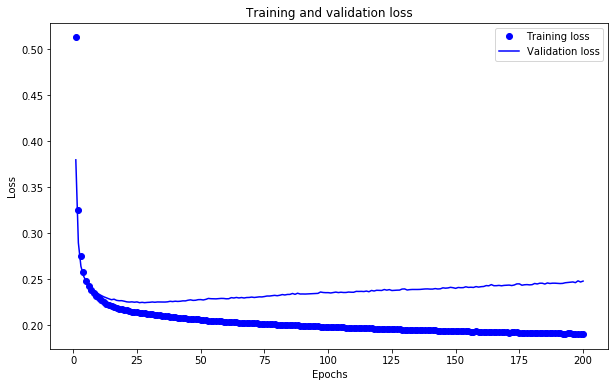

In [27]:
# plot the results of loss values from the training set and validtion set
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['accuracy']) + 1)

plt.figure(figsize=(10,6))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Now, we can plot the results of accuracy from the training and validation set.

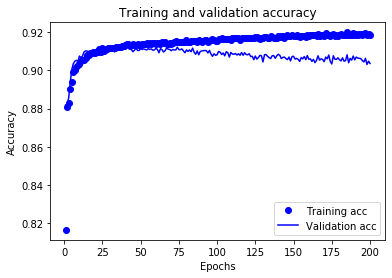

In [28]:
# plot the results of accuracy from the training set and validtion set
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [29]:
# Compute the confusion matrix
y_preds = model.predict(X_valid)
y_preds = (y_preds>0.5).astype(int)
print('confusion matrix')
print(sklearn.metrics.confusion_matrix(y_valid,y_preds))

# Compute accuracy
print('accuracy = '+ str(sklearn.metrics.accuracy_score(y_valid,y_preds)))


# Compute Precision
print('precision = '+str(sklearn.metrics.precision_score(y_valid,y_preds)))
      
# Compute Recall
print('recall = '+ str(sklearn.metrics.recall_score(y_valid,y_preds)))

# Compute F1 score
print('F1 score = '+ str(sklearn.metrics.f1_score(y_valid,y_preds)))

confusion matrix
[[6387  227]
 [ 496  390]]
accuracy = 0.9036
precision = 0.6320907617504052
recall = 0.4401805869074492
F1 score = 0.5189620758483035


This simple works well in our training set and validation set(with accuracy about 0.9).

However, this model didn't perform well on our test set. When I used all the training data to train this model, the public score of this model is about 0.62. Why this happened? Well, I think the reason is about our imbalanced data, there are too many 0s in 'Target'. As a result, our model prefer to give us many 0s, which leads to our fail on testing dataset.

Now, in order to deal with the issue of imbalanced dataset, I use a weighted model.

## Calculate class_weights. 

In [30]:
# Calculate class weight
NotOver50k, Over50k = np.bincount(train_data.Target)
total_count = len(train_data.Target)

weight_no_over50k = (1/NotOver50k)*(total_count)/2.0
weight_over50k = (1/Over50k)*(total_count)/2.0

class_weights = {0:weight_no_over50k, 1:weight_over50k}

Now, we can use class_weights as an argument when we construct our second NN model.

<mark>DL model draft:<mark>  
    
3 hidden layers in this model.

The first hidden layer: 16 units with 'relu' activation function.

The second hidden layer: 16 units with 'relu' activation function.

The third hidden layer: 1 unit with 'sigmoid' activation function.
    
I choose the 'rmsprop' optimizer, 'binary_crossentropy' loss function, and the 'accuracy' metrics.
    
<mark>parameter initialization:<mark>
    
I use 200 epochs to train my model. The batch_size of my model is 512.

<mark>parameter tuning:<mark>
    
Because I think this model did well in my training dataset, I didn't tune it's parameters.

Now, let's construct our second NN model.

In [31]:
# Use weighted model!
model = models.Sequential()
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=200,
                    batch_size=512,
                    validation_data=(X_valid, y_valid),
                    class_weight=class_weights)

Train on 22014 samples, validate on 7500 samples
Epoch 1/200
22014/22014 [==============================] - 0s 16us/step - loss: 0.6550 - accuracy: 0.8089 - val_loss: 0.4914 - val_accuracy: 0.7552
Epoch 2/200
22014/22014 [==============================] - 0s 7us/step - loss: 0.5194 - accuracy: 0.7345 - val_loss: 0.4661 - val_accuracy: 0.7255
Epoch 3/200
22014/22014 [==============================] - 0s 11us/step - loss: 0.4516 - accuracy: 0.7318 - val_loss: 0.4607 - val_accuracy: 0.7333
Epoch 4/200
22014/22014 [==============================] - 0s 7us/step - loss: 0.4220 - accuracy: 0.7471 - val_loss: 0.4470 - val_accuracy: 0.7511
Epoch 5/200
22014/22014 [==============================] - 0s 9us/step - loss: 0.4066 - accuracy: 0.7619 - val_loss: 0.4354 - val_accuracy: 0.7620
Epoch 6/200
22014/22014 [==============================] - 0s 7us/step - loss: 0.3976 - accuracy: 0.7724 - val_loss: 0.4339 - val_accuracy: 0.7659
Epoch 7/200
22014/22014 [==============================] - 0s 7us/s

After constructing our weighted model, we can plot the results of loss values from the training and validation set.

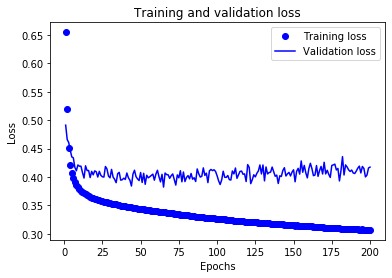

In [32]:
# plot the results of loss values from the training set and validtion set
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['accuracy']) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Also, we can plot the results of accuracy from the training and validation set.

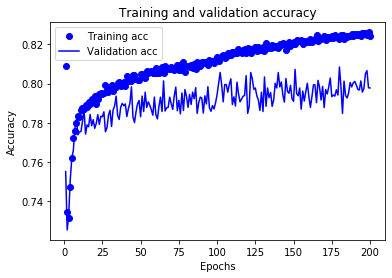

In [33]:
#plt.clf()
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [34]:
# Compute the confusion matrix
y_preds = model.predict(X_valid)
y_preds = (y_preds>0.5).astype(int)
print('confusion matrix')
print(sklearn.metrics.confusion_matrix(y_valid,y_preds))

# Compute accuracy
print('accuracy = '+ str(sklearn.metrics.accuracy_score(y_valid,y_preds)))


# Compute Precision
print('precision = '+str(sklearn.metrics.precision_score(y_valid,y_preds)))
      
# Compute Recall
print('recall = '+ str(sklearn.metrics.recall_score(y_valid,y_preds)))

# Compute F1 score
print('F1 score = '+ str(sklearn.metrics.f1_score(y_valid,y_preds)))

confusion matrix
[[5254 1360]
 [ 157  729]]
accuracy = 0.7977333333333333
precision = 0.3489707994255625
recall = 0.8227990970654627
F1 score = 0.4900840336134454


When I used all the training data to train this model, the public score of this model is about 0.83 (the private score is also about 0.82). By using weighted model, we successfully overcome the problem of imbalanced training dataset.

Now, we should try to improve our performance in training data. 

Let's add two layers and units.

(After we get great performance in training data, we should deal with the overfitting problem.)

Train on 22014 samples, validate on 7500 samples
Epoch 1/200
22014/22014 [==============================] - 1s 31us/step - loss: 0.4784 - accuracy: 0.7330 - val_loss: 0.4848 - val_accuracy: 0.7391
Epoch 2/200
22014/22014 [==============================] - 1s 26us/step - loss: 0.4038 - accuracy: 0.7715 - val_loss: 0.3936 - val_accuracy: 0.7897
Epoch 3/200
22014/22014 [==============================] - 0s 19us/step - loss: 0.3876 - accuracy: 0.7810 - val_loss: 0.3727 - val_accuracy: 0.7991
Epoch 4/200
22014/22014 [==============================] - 1s 23us/step - loss: 0.3715 - accuracy: 0.7885 - val_loss: 0.3757 - val_accuracy: 0.7913
Epoch 5/200
22014/22014 [==============================] - 0s 18us/step - loss: 0.3641 - accuracy: 0.7884 - val_loss: 0.4322 - val_accuracy: 0.7645
Epoch 6/200
22014/22014 [==============================] - 0s 22us/step - loss: 0.3581 - accuracy: 0.7913 - val_loss: 0.3333 - val_accuracy: 0.8220
Epoch 7/200
22014/22014 [==============================] - 0s 1

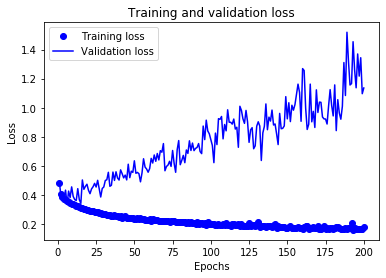

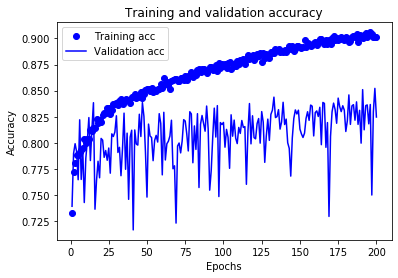

confusion matrix
[[5568 1046]
 [ 269  617]]
accuracy = 0.8246666666666667
precision = 0.3710162357185809
recall = 0.6963882618510158
F1 score = 0.4841114162416634


In [41]:
model = models.Sequential()
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=200,
                    batch_size=512,
                    validation_data=(X_valid, y_valid),
                    class_weight=class_weights)

# plot the results of loss values from the training set and validtion set
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['accuracy']) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#plt.clf()
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Compute the confusion matrix
y_preds = model.predict(X_valid)
y_preds = (y_preds>0.5).astype(int)
print('confusion matrix')
print(sklearn.metrics.confusion_matrix(y_valid,y_preds))

# Compute accuracy
print('accuracy = '+ str(sklearn.metrics.accuracy_score(y_valid,y_preds)))


# Compute Precision
print('precision = '+str(sklearn.metrics.precision_score(y_valid,y_preds)))
      
# Compute Recall
print('recall = '+ str(sklearn.metrics.recall_score(y_valid,y_preds)))

# Compute F1 score
print('F1 score = '+ str(sklearn.metrics.f1_score(y_valid,y_preds)))

## Deal with overfitting

Our model has already performed well on our training data.

Now, let's use 'dropout' method to deal with the overfitting problem.

Train on 22014 samples, validate on 7500 samples
Epoch 1/50
22014/22014 [==============================] - 2s 80us/step - loss: 0.5662 - accuracy: 0.6973 - val_loss: 0.4001 - val_accuracy: 0.7769
Epoch 2/50
22014/22014 [==============================] - 1s 32us/step - loss: 0.4537 - accuracy: 0.7542 - val_loss: 0.3703 - val_accuracy: 0.7779
Epoch 3/50
22014/22014 [==============================] - 1s 27us/step - loss: 0.4294 - accuracy: 0.7587 - val_loss: 0.4032 - val_accuracy: 0.7615
Epoch 4/50
22014/22014 [==============================] - 1s 24us/step - loss: 0.4108 - accuracy: 0.7661 - val_loss: 0.3641 - val_accuracy: 0.7780
Epoch 5/50
22014/22014 [==============================] - 1s 25us/step - loss: 0.4001 - accuracy: 0.7774 - val_loss: 0.4188 - val_accuracy: 0.7597
Epoch 6/50
22014/22014 [==============================] - 1s 41us/step - loss: 0.3936 - accuracy: 0.7825 - val_loss: 0.3717 - val_accuracy: 0.7755
Epoch 7/50
22014/22014 [==============================] - 1s 41us/ste

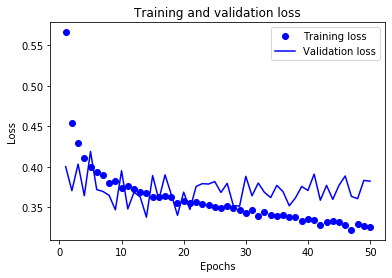

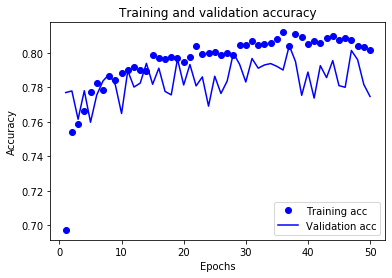

confusion matrix
[[5049 1565]
 [ 125  761]]
accuracy = 0.7746666666666666
precision = 0.3271711092003439
recall = 0.8589164785553047
F1 score = 0.4738480697384807


In [45]:
model = models.Sequential()
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=50,
                    batch_size=512,
                    validation_data=(X_valid, y_valid),
                    class_weight=class_weights)

# plot the results of loss values from the training set and validtion set
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['accuracy']) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#plt.clf()
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Compute the confusion matrix
y_preds = model.predict(X_valid)
y_preds = (y_preds>0.5).astype(int)
print('confusion matrix')
print(sklearn.metrics.confusion_matrix(y_valid,y_preds))

# Compute accuracy
print('accuracy = '+ str(sklearn.metrics.accuracy_score(y_valid,y_preds)))


# Compute Precision
print('precision = '+str(sklearn.metrics.precision_score(y_valid,y_preds)))
      
# Compute Recall
print('recall = '+ str(sklearn.metrics.recall_score(y_valid,y_preds)))

# Compute F1 score
print('F1 score = '+ str(sklearn.metrics.f1_score(y_valid,y_preds)))

## Final DNN model

Now, I can use all the training data to train this model.

In [47]:
# Use whole training data to train our final model

model = models.Sequential()
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train,
                    y_train,
                    epochs=50,
                    batch_size=512,
                    class_weight=class_weights)

Epoch 1/50
29514/29514 [==============================] - 1s 48us/step - loss: 0.5404 - accuracy: 0.7186
Epoch 2/50
29514/29514 [==============================] - 1s 25us/step - loss: 0.4468 - accuracy: 0.7585
Epoch 3/50
29514/29514 [==============================] - 1s 24us/step - loss: 0.4242 - accuracy: 0.7700
Epoch 4/50
29514/29514 [==============================] - 1s 25us/step - loss: 0.4082 - accuracy: 0.7787
Epoch 5/50
29514/29514 [==============================] - 1s 25us/step - loss: 0.4013 - accuracy: 0.7742
Epoch 6/50
29514/29514 [==============================] - 1s 24us/step - loss: 0.3923 - accuracy: 0.7889
Epoch 7/50
29514/29514 [==============================] - 1s 27us/step - loss: 0.3889 - accuracy: 0.7794
Epoch 8/50
29514/29514 [==============================] - 1s 24us/step - loss: 0.3877 - accuracy: 0.7906
Epoch 9/50
29514/29514 [==============================] - 1s 22us/step - loss: 0.3823 - accuracy: 0.7877
Epoch 10/50
29514/29514 [==============================

After training our final model, we can then use this model to predict our final answer (use our test dataset). 

## Using a trained network to generate predictions on testing data

In [49]:
#Using a trained network to generate predictions on new data
y_preds=model.predict(X_test)
y_preds=(y_preds>0.5).astype(int)
answer=pd.DataFrame(y_preds)

X_test=pd.read_csv('/Users/Stylewsxcde991/Desktop/物聯網下商管統計分析/qbs-competition-1/data/test.csv',index_col=0)
answer.index=X_test.index
result = pd.read_csv('/Users/Stylewsxcde991/Desktop/物聯網下商管統計分析/qbs-competition-1/data/sub_try.csv',index_col=0)
result['Target'] = answer
result.to_csv('/Users/Stylewsxcde991/Desktop/物聯網下商管統計分析/qbs-competition-1/data/Result_1.csv')

After some dataframe operations, we can then export our answer.

Now, let's see the prediction result of our final model.

## The prediction result:
    
As we talked before, by using our final weighted model, in Kaggle competition, the public score of this model is about 0.83 (the private score is also about 0.82).
    
In my opinion, this model's great performance in Kaggle competition means this model can effectively predict whether a person makes over 50K a year. That is to say, if we want to predict if a person makes over 50K a year, our final model is trustable and reasonable.

## Learning progress and reflection

To be honest, when I first built a NN model for this assignment, the result was very bad. Even if I used the weighted model technique, I still got bad results (accuracy scores are very unstable).
    
In order to overcome this situation, I started to do explorative data analysis and I found that 'fnlwgt' is almost unrelated with 'Target'. 
    
Therefore, I decided to drop 'fnlwgt'. Fortunately, my models started to improve and got trustable predictions.
    
In short, never forget to do EDA before modeling.